# COVID 19 classification

In [66]:
 import os
 os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
 os.environ['CUDA_VISIBLE_DEVICES']='1'

In [67]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [68]:
from fastai.vision import *
from fastai.metrics import error_rate
import fastai; fastai.__version__

'1.0.60'

In [103]:
#!pip list


If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [69]:
bs = 16
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
size_1 = 256
size_2 = 512

## data

In [70]:
path ='/home/robert/data/covid/'; path

'/home/robert/data/covid/'

### Load Normal and pneumonia from dataset (including covids!) 

In [72]:
dfTrain = pd.read_csv(path+'train_split_v3.csv', header=None)
dfTrain['valid'] = 0
dfTrain[0] = 'train/processed/' + dfTrain[0].astype(str)
dfTrain.head()

idx_pa = dfTrain[1] == "COVID-19"  # Get COVID to augment.
dfTrain_covid =  dfTrain[idx_pa]
print(len (dfTrain_covid))
#augment de training covid data 2^3
for i in range(3):
    dfTrain_covid = dfTrain_covid.append(dfTrain_covid)
print('Org train '+str(len (dfTrain)))
dfTrain = dfTrain.append(dfTrain_covid)
print('Augmented train '+str(len (dfTrain)))


# adding padchest
dfTrain_padchest = pd.read_csv(path+'padchest/train_split_np.csv', header=None)
dfTrain_padchest['valid'] = 0
dfTrain_padchest[0] = 'padchest/testNP/processed/' + dfTrain_padchest[0].astype(str)
dfTrain = dfTrain.append(dfTrain_padchest)

print('Final train '+str(len (dfTrain)))

271
Org train 13687
Augmented train 15855
Final train 16890


### not done in v3 Load COVID for training from covid_vicorob

In [107]:
#dfTrainCovid = pd.read_csv(path+'covid_vicorob/covid_vicorob.csv', header=None)
#dfTrainCovid['valid'] = 0
#dfTrainCovid[0] = 'covid_vicorob/' + dfTrainCovid[0].astype(str)
#dfTrainCovid.head()
#print(len (dfTrainCovid))
#augment de training covid data 2^3
#for i in range(2):
#    dfTrainCovid = dfTrainCovid.append(dfTrainCovid)
#dfTrain = dfTrain.append(dfTrainCovid)
#print(len (dfTrain))


13687


### Validation data from Seram & Normals

In [7]:
dfTest = pd.read_csv(path+'test_split_v3.csv',header=None)
dfTest['valid'] = 1
dfTest[0] = 'test/processed/' + dfTest[0].astype(str)
dfTest.head()

0          1  valid
0  test/processed/SARS-10.1148rg.242035193-g04mr3...  pneumonia      1
1  test/processed/streptococcus-pneumoniae-pneumo...  pneumonia      1
2  test/processed/streptococcus-pneumoniae-pneumo...  pneumonia      1
3  test/processed/streptococcus-pneumoniae-pneumo...  pneumonia      1
4  test/processed/streptococcus-pneumoniae-pneumo...  pneumonia      1

In [109]:
# dfTestCovid = pd.read_csv(path+'seram/covid_seram.csv',header=None)
# dfTestCovid['valid'] = 1
# dfTestCovid[0] = 'seram/' + dfTestCovid[0].astype(str)
# dfTestCovid.head()
# dfTest= dfTest.append(dfTestCovid)

In [8]:
df = dfTrain.append(dfTest)
df.head()

0          1  valid
0  train/processed/SARS-10.1148rg.242035193-g04mr...  pneumonia      0
1  train/processed/SARS-10.1148rg.242035193-g04mr...  pneumonia      0
2  train/processed/SARS-10.1148rg.242035193-g04mr...  pneumonia      0
3  train/processed/SARS-10.1148rg.242035193-g04mr...  pneumonia      0
4  train/processed/SARS-10.1148rg.242035193-g04mr...  pneumonia      0

In [9]:
np.random.seed(42)

# src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
#        .split_by_rand_pct(0.2)
#        .label_from_df(label_delim=' '))

src = (ImageList.from_df(df=df,path=path)
    .split_from_df(col='valid')
    .label_from_df())

In [10]:
# original tfms = get_tranasforms(do_flip=False) 
# allowing horizontal flips only. 
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
#tfms = get_transforms(flip_vert=False)

In [11]:
#data = #ImageDataBunch.from_df(path=Path('data'), df=df, ds_tfms=get_transforms(), size=224, bs=32)

data = (src.transform(tfms, size=size_1)
        .databunch().normalize(imagenet_stats))
data.batch_size=bs
# lesson 1 data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=224, resize_method=ResizeMethod.SQUISH)

In [12]:
#data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=tfms, size=224, resize_method=ResizeMethod.SQUISH)

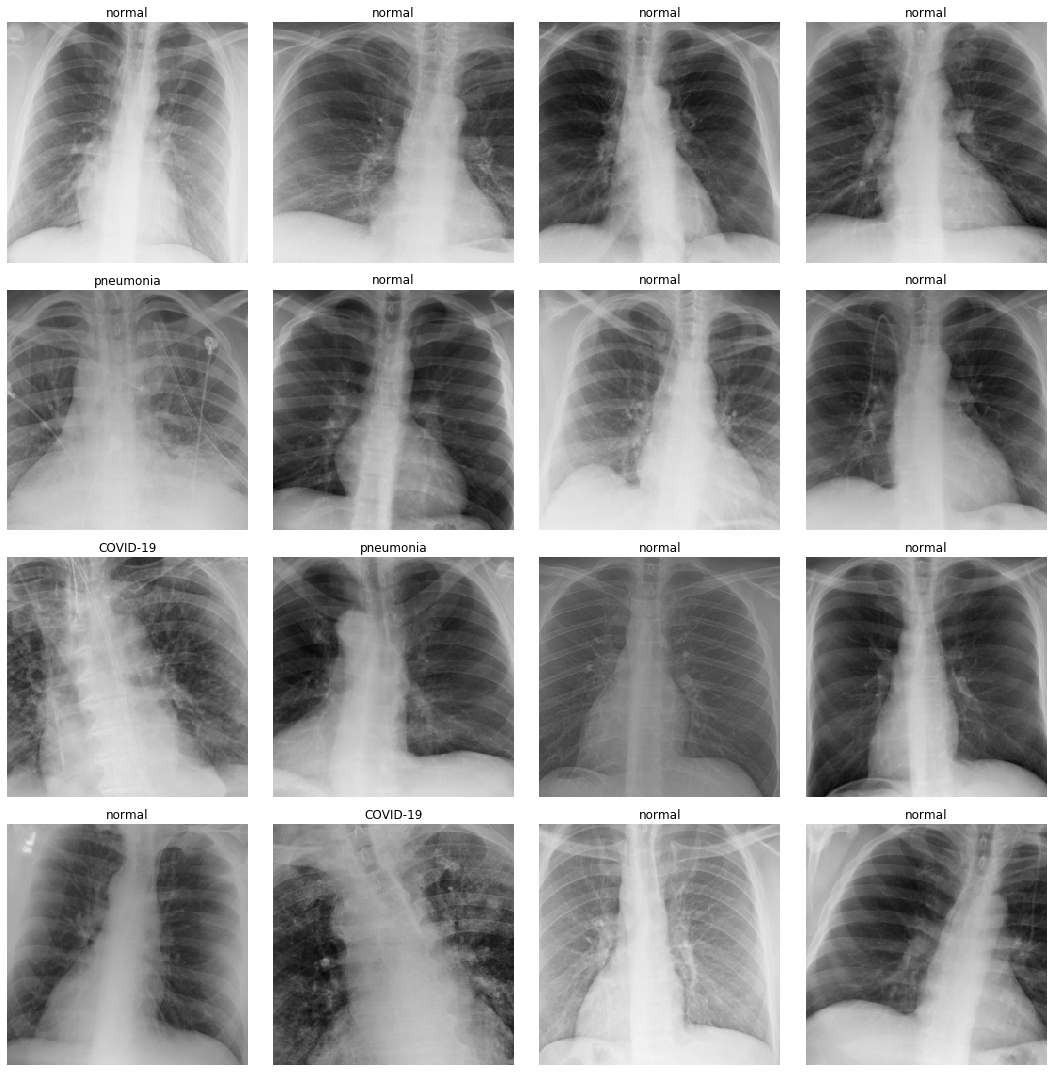

In [13]:
data.show_batch(rows=10,figsize=(15,15))

In [14]:
data.train_ds

LabelList (15855 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /home/robert/data/covid

In [15]:
data.valid_ds


LabelList (1579 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /home/robert/data/covid

### Convert to grayscale

In [16]:
for itemList in ["train_dl", "valid_dl", "fix_dl", "test_dl"]:
    itemList = getattr(data, itemList)
    if itemList: itemList.x.convert_mode = "L"

## learner

In [17]:
'''class fbeta_binary(Callback):
    "Computes the f_beta between preds and targets for binary text classification"

    def __init__(self, beta2 = 1, eps=1e-9,sigmoid = True):      
        self.beta2=beta2**2
        self.eps = eps
        self.sigmoid = sigmoid
    
    def on_epoch_begin(self, **kwargs):
        self.TP = 0
        self.total_y_pred = 0   
        self.total_y_true = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        y_pred = last_output
        y_pred = y_pred.softmax(dim = 1)        
        y_pred = y_pred.argmax(dim=1)
        y_true = last_target.float()
        
        self.TP += ((y_pred==1) * (y_true==1)).float().sum()
        self.total_y_pred += (y_pred==1).float().sum()
        self.total_y_true += (y_true==1).float().sum()
    
    def on_epoch_end(self, **kwargs):
        prec = self.TP/(self.total_y_pred+self.eps)
        rec = self.TP/(self.total_y_true+self.eps)
        res = (prec*rec)/(prec*self.beta2+rec+self.eps)*(1+self.beta2)        
        #self.metric = res.mean()
        self.metric = res     
'''

'class fbeta_binary(Callback):\n    "Computes the f_beta between preds and targets for binary text classification"\n\n    def __init__(self, beta2 = 1, eps=1e-9,sigmoid = True):      \n        self.beta2=beta2**2\n        self.eps = eps\n        self.sigmoid = sigmoid\n    \n    def on_epoch_begin(self, **kwargs):\n        self.TP = 0\n        self.total_y_pred = 0   \n        self.total_y_true = 0\n    \n    def on_batch_end(self, last_output, last_target, **kwargs):\n        y_pred = last_output\n        y_pred = y_pred.softmax(dim = 1)        \n        y_pred = y_pred.argmax(dim=1)\n        y_true = last_target.float()\n        \n        self.TP += ((y_pred==1) * (y_true==1)).float().sum()\n        self.total_y_pred += (y_pred==1).float().sum()\n        self.total_y_true += (y_true==1).float().sum()\n    \n    def on_epoch_end(self, **kwargs):\n        prec = self.TP/(self.total_y_pred+self.eps)\n        rec = self.TP/(self.total_y_true+self.eps)\n        res = (prec*rec)/(prec*self

In [18]:
#learn = cnn_learner(data, models.resnet34, metrics=error_rate)

arch = models.resnet50
#arch = models.densenet161
#learn = cnn_learner(data, arch, metrics=[accuracy, Precision(), AUROC(), error_rate])
learn = cnn_learner(data, arch, metrics=[accuracy, Precision(), error_rate])


In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-04
Min loss divided by 10: 1.91E-03


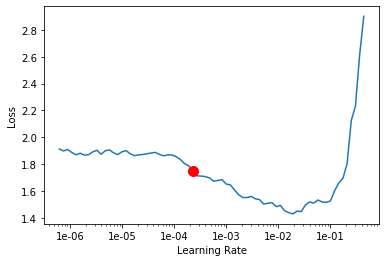

In [20]:
learn.recorder.plot(suggestion=True)

In [21]:
lr = 1e-03

In [22]:
learn.fit_one_cycle(10, slice(lr))

/home/robert/miniconda2/envs/fastai-3.6/lib/python3.6/site-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


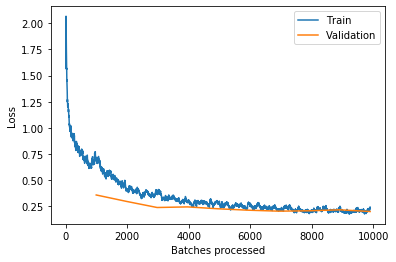

In [23]:
learn.recorder.plot_losses()

In [24]:
learn.save('stage-1-'+str(size_1)+'-dn50')

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [26]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['COVID-19', 'normal', 'pneumonia'], 3, 15855, 1579)

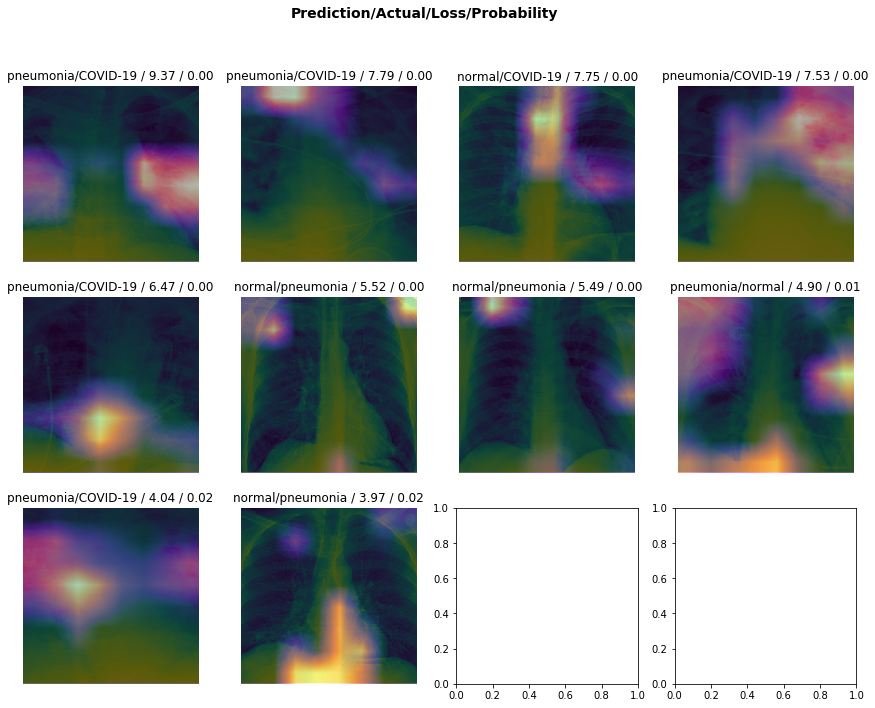

In [27]:
interp.plot_top_losses(10, figsize=(15,11), heatmap= True)

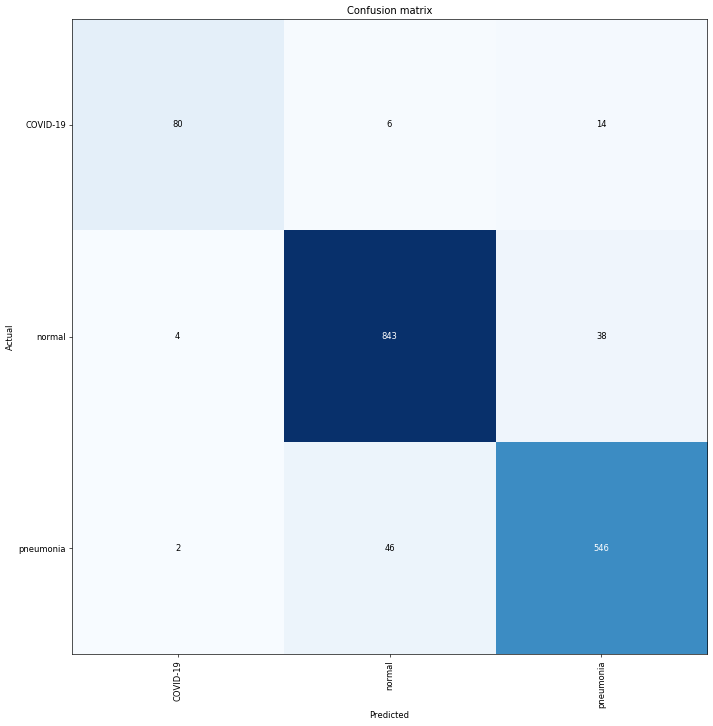

In [28]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [29]:
interp.most_confused(min_val=1)

[('pneumonia', 'normal', 46),
 ('normal', 'pneumonia', 38),
 ('COVID-19', 'pneumonia', 14),
 ('COVID-19', 'normal', 6),
 ('normal', 'COVID-19', 4),
 ('pneumonia', 'COVID-19', 2)]

In [30]:
learn.unfreeze()

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-06
Min loss divided by 10: 5.75E-07


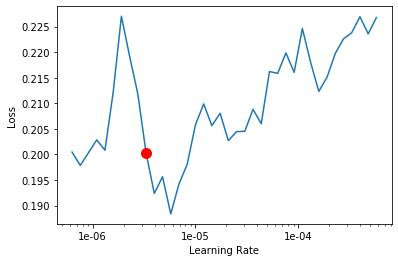

In [32]:
learn.recorder.plot(suggestion=True)

In [33]:
learn.fit_one_cycle(10,slice(1e-5, lr/2))

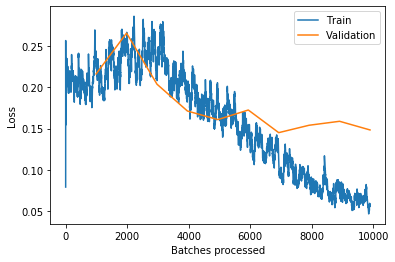

In [34]:
learn.recorder.plot_losses()

In [35]:
learn.save('stage-2-'+str(size_1)+'256-rn50')


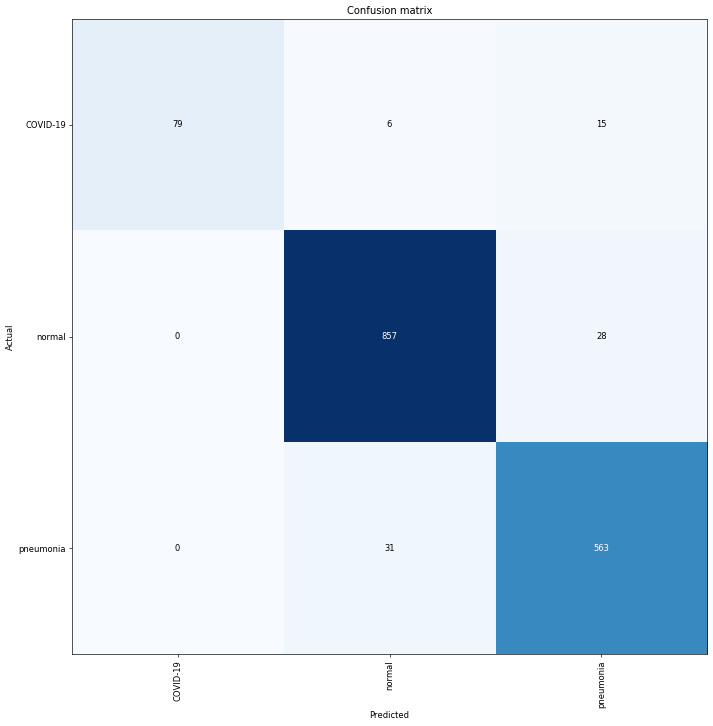

In [36]:

interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### increasing image size

In [37]:
data = (src.transform(tfms, size=size_2)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.batch_size = bs
data.train_ds[0][0].shape

torch.Size([1, 512, 512])

In [38]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


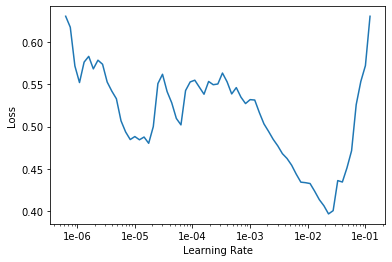

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
lr=1e-3/2

In [41]:
learn.fit_one_cycle(10, slice(lr))

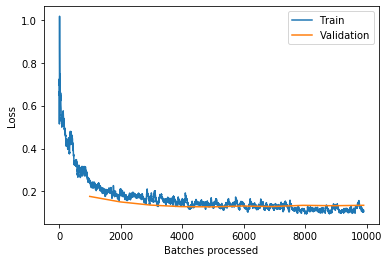

In [42]:
learn.recorder.plot_losses()

In [43]:
learn.save('stage-1-'+str(size_2)+'-rn50')

In [44]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


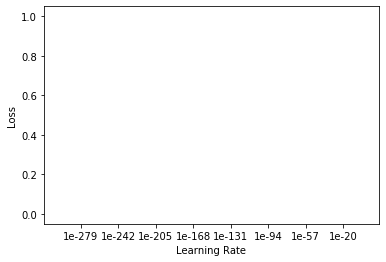

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(10, slice(1e-5, lr/5))

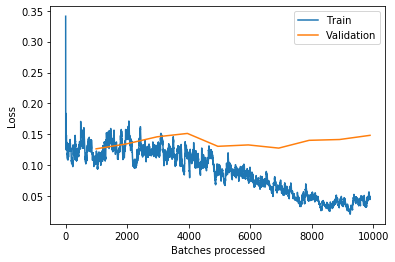

In [48]:
learn.recorder.plot_losses()

In [49]:
learn.save('stage-2-'+str(size_2)+'-rn50')


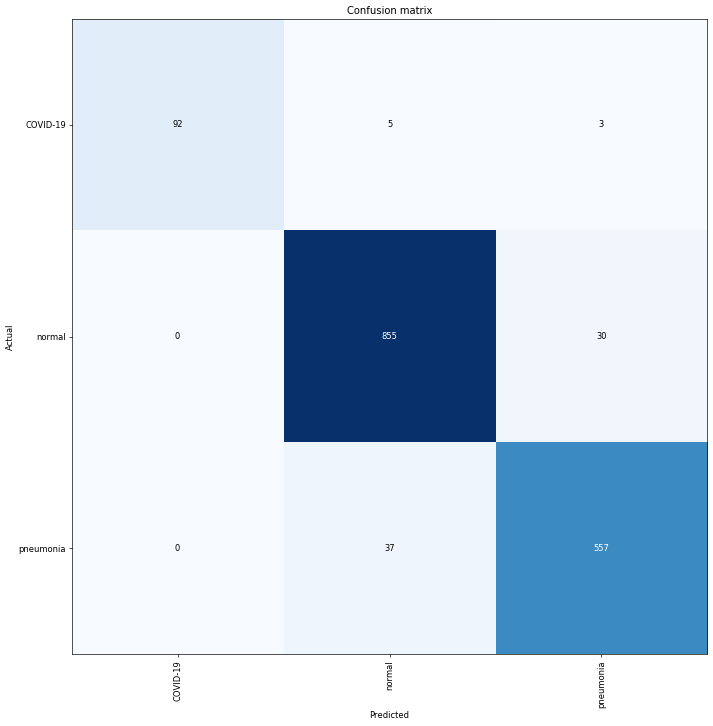

In [50]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

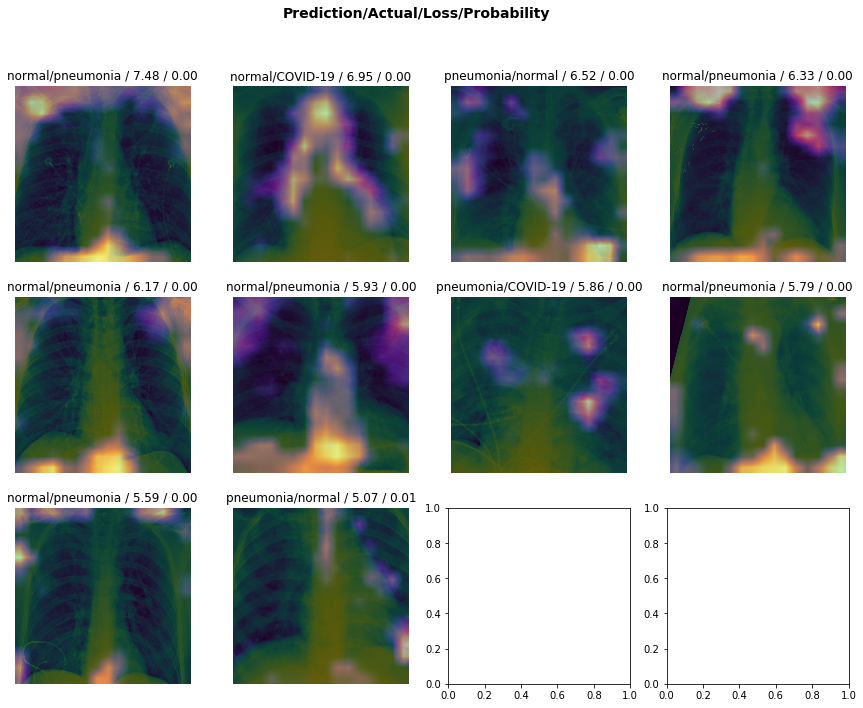

In [51]:
interp.plot_top_losses(10, figsize=(15,11), largest=True, heatmap= True)

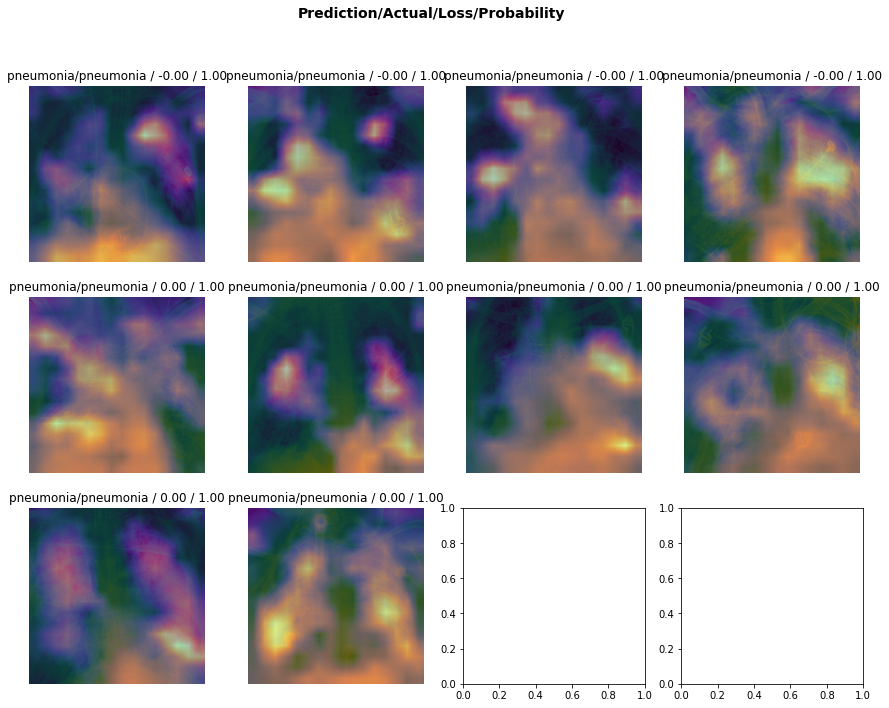

In [52]:
interp.plot_top_losses(10, figsize=(15,11), largest=False, heatmap= True)

In [53]:
learn.export('trainedAllData_resnet_ROI_'+str(size_2)+'_export.pkl')

### Test on new data

In [54]:
learn = load_learner(path,'trainedAllData_resnet_ROI_'+str(size_2)+'_export.pkl')


#preds,y = learn.get_preds()



In [61]:
# Data from trueta, Tic Salut, Udiat
dfTest = pd.read_csv(path+'covid_local/covid_local_APonly.csv',header=None)
dfTest[0] = 'covid_local/processed/' + dfTest[0].astype(str)

#CSMS (earlier files <20 cases)
dfTest2 = pd.read_csv(path+'CSMS/CSMS.csv',header=None)
dfTest2[0] = 'CSMS/processed/' + dfTest2[0].astype(str)
dfTest2.head()
dfTest = dfTest.append(dfTest2)

# padchest to include normals and pneumonia (not used for training/validation/testing)
dfTest3 = pd.read_csv(path+'padchest/test_split_np.csv',header=None)
dfTest3[0] = 'padchest/testNP/processed/' + dfTest3[0].astype(str)
dfTest3.head()
dfTest = dfTest.append(dfTest3)

#salutms (120 cases)
dfTest4 = pd.read_csv(path+'salutms/salutms.csv',header=None)
dfTest4[0] = 'salutms/processed/' + dfTest4[0].astype(str)
dfTest4.head()
dfTest = dfTest.append(dfTest4)


In [62]:
src = (ImageList.from_df(df=dfTest,path=path,convert_mode='L')
    .split_none()
    .label_from_df())

test = (src.transform(tfms, size=512)
        .databunch(no_check=False,bs=1).normalize(imagenet_stats))
test.train_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f3a94dfb518>, device=device(type='cuda', index=0), tfms=[functools.partial(<function _normalize_batch at 0x7f3a9b29a400>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=False)], collate_fn=<function data_collate at 0x7f3aa36d10d0>)

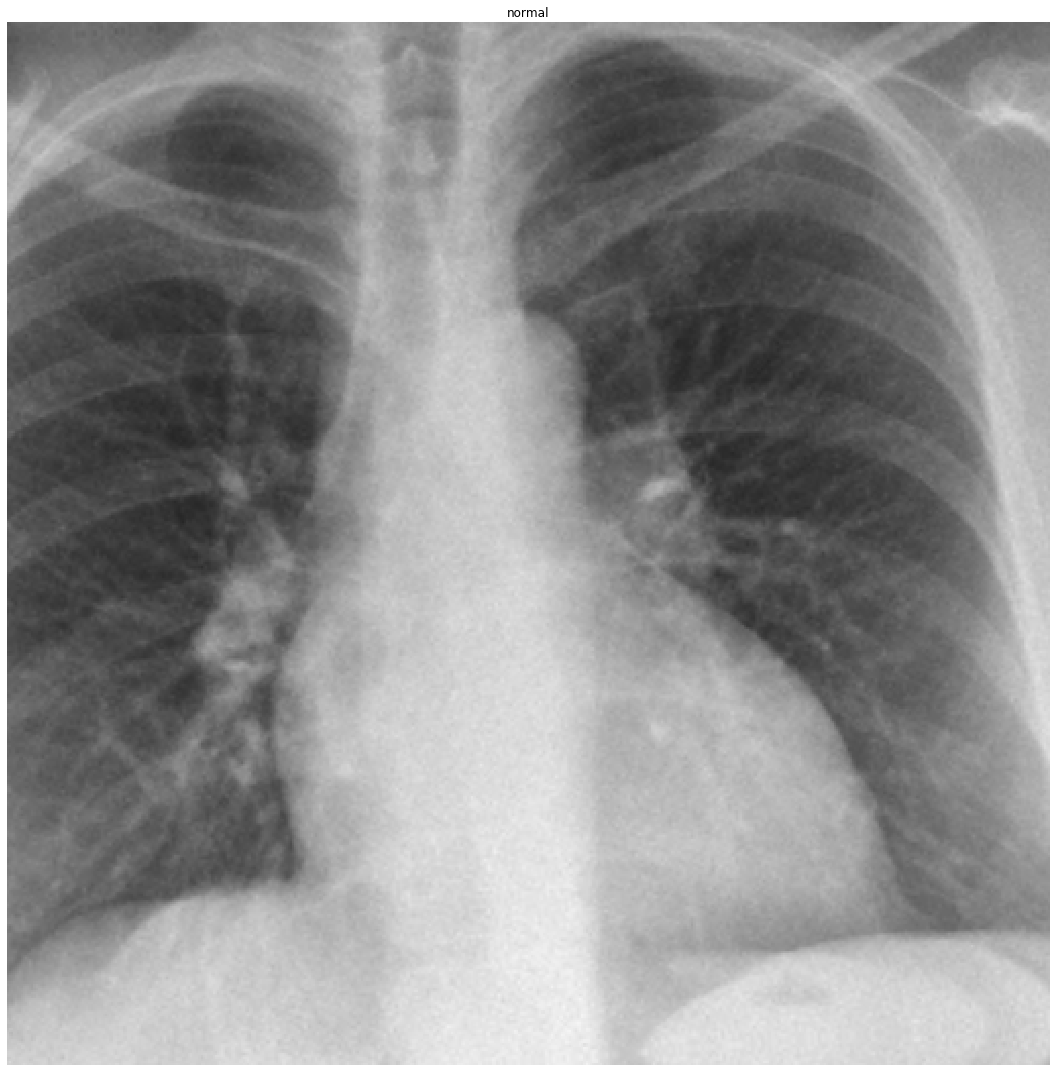

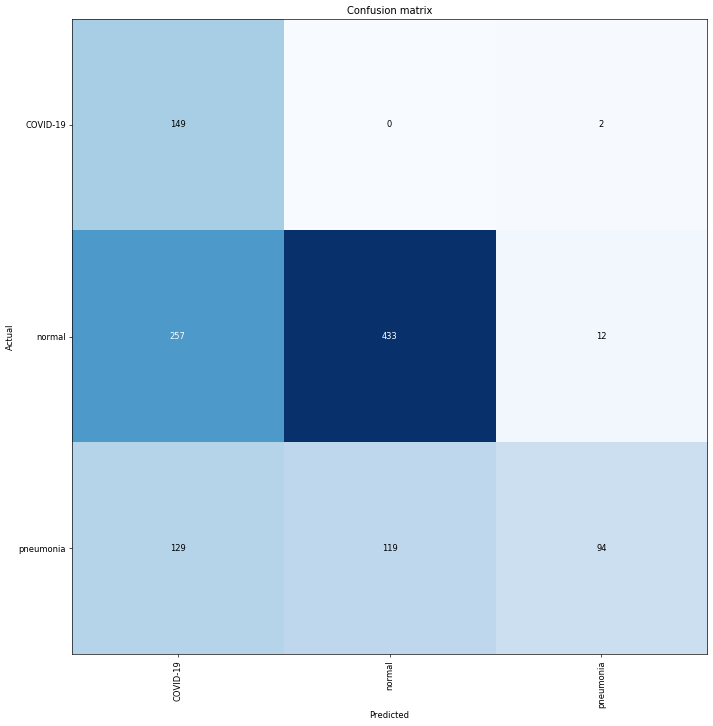

In [64]:
test.valid_dl = test.train_dl

test.show_batch(rows=13,figsize=(15,15))

for itemList in ["train_dl", "valid_dl", "fix_dl", "test_dl"]:
    itemList = getattr(test, itemList)
    if itemList: itemList.x.convert_mode = "L"


learn.data.valid_dl = test.train_dl
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

#len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [58]:
log_preds, y = learn.get_preds()

predIdxs = np.argmax(log_preds.numpy(), axis=1)
print(exp(log_preds))



tensor([[1.4676, 1.0190, 1.8177],
        [1.4744, 1.8436, 1.0001],
        [1.8796, 1.4299, 1.0114],
        ...,
        [2.4399, 1.1141, 1.0000],
        [2.7150, 1.0012, 1.0000],
        [2.6732, 1.0168, 1.0001]])


In [59]:
len(data.valid_ds)
predIdxs
log_preds
predIdxs

array([2, 1, 0, 0, ..., 1, 0, 0, 0])

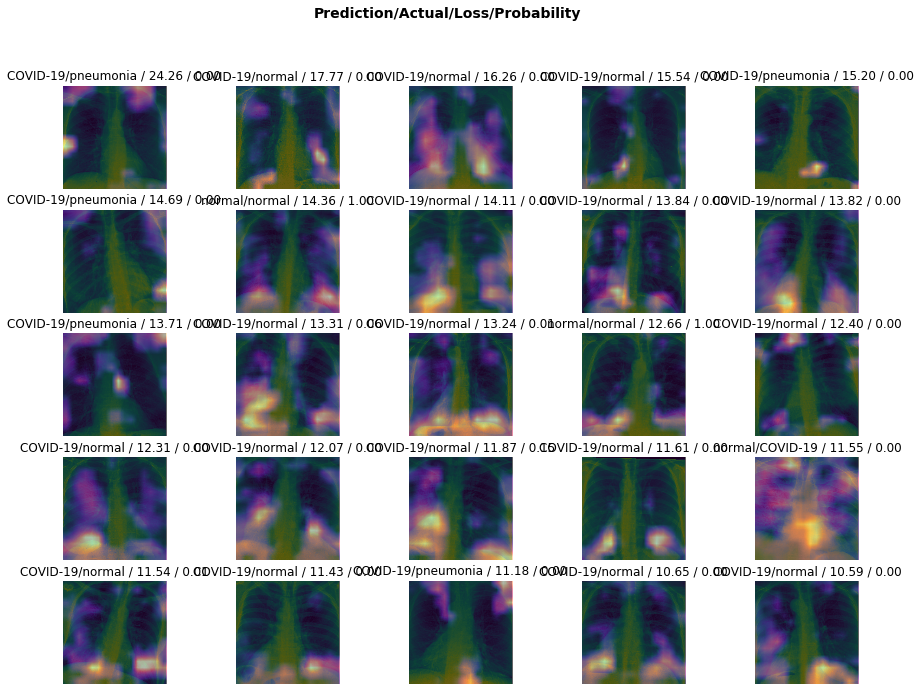

In [65]:
interp.plot_top_losses(25, figsize=(15,11), largest=True, heatmap= True)

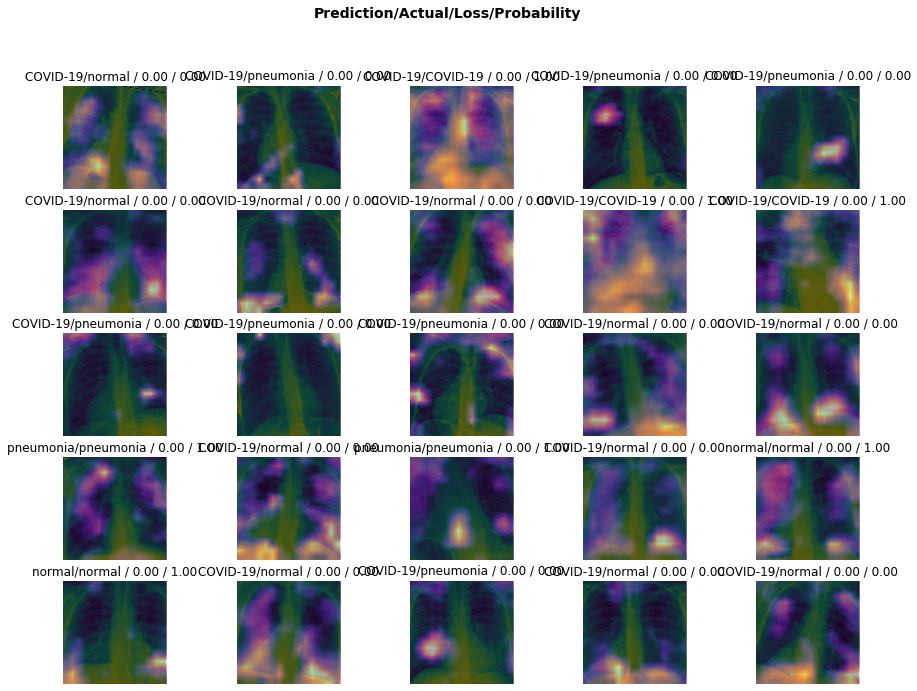

In [60]:
interp.plot_top_losses(25, figsize=(15,11), largest=False, heatmap= True)